In [32]:
import os
import onnx
import torch
import torchvision

import numpy as np
import pandas as pd
import onnxruntime as ort
import matplotlib.pyplot as plt


In [25]:
torch.cuda_version, ort.__version__

('10.2', '1.8.1')

## Load results

Results where obtained by running:
```
python benchmark.py -f pytorch -m all -b 6 -d cpu cuda -e -v
python benchmark.py -f onnx -m all -b 6 -d cpu cuda -e -v
```

In [51]:
results_dir = '../results'
results = [f'{results_dir}/{f}' for f in os.listdir(results_dir)]
results

['../results/onnx.csv', '../results/pytorch.csv']

In [52]:
dfs = [pd.read_csv(f) for f in results]

df = pd.concat(dfs, ignore_index=True)

## Analysis

In [83]:
df

,model,device,bs,time,engine
0,resnet18,cpu,1,11.002541,onnx
1,resnet18,cpu,2,12.000203,onnx
2,resnet18,cpu,4,13.999760,onnx
3,resnet18,cpu,8,11.125118,onnx
4,resnet18,cpu,16,11.624947,onnx
...,...,...,...,...,...
355,mnasnet0_5,cuda,2,5.000472,pytorch
356,mnasnet0_5,cuda,4,3.249943,pytorch
357,mnasnet0_5,cuda,8,1.375139,pytorch
358,mnasnet0_5,cuda,16,0.625044,pytorch


## Plot results

In [26]:
df

,model,device,bs,time,engine
0,resnet18,cpu,1,11.002541,onnx
1,resnet18,cpu,2,12.000203,onnx
2,resnet18,cpu,4,13.999760,onnx
3,resnet18,cpu,8,11.125118,onnx
4,resnet18,cpu,16,11.624947,onnx
...,...,...,...,...,...
367,mnasnet0_5,cuda,2,5.464196,pytorch
368,mnasnet0_5,cuda,4,2.225757,pytorch
369,mnasnet0_5,cuda,8,1.241535,pytorch
370,mnasnet0_5,cuda,16,0.620216,pytorch


In [73]:
df.model.nunique(), df.model.unique().tolist()

(15,
 ['resnet18',
  'resnet50',
  'alexnet',
  'vgg16',
  'vgg19',
  'squeezenet1_1',
  'densenet121',
  'inception_v3',
  'googlenet',
  'mobilenet_v2',
  'mobilenet_v3_large',
  'mobilenet_v3_small',
  'resnext50_32x4d',
  'wide_resnet50_2',
  'mnasnet0_5'])

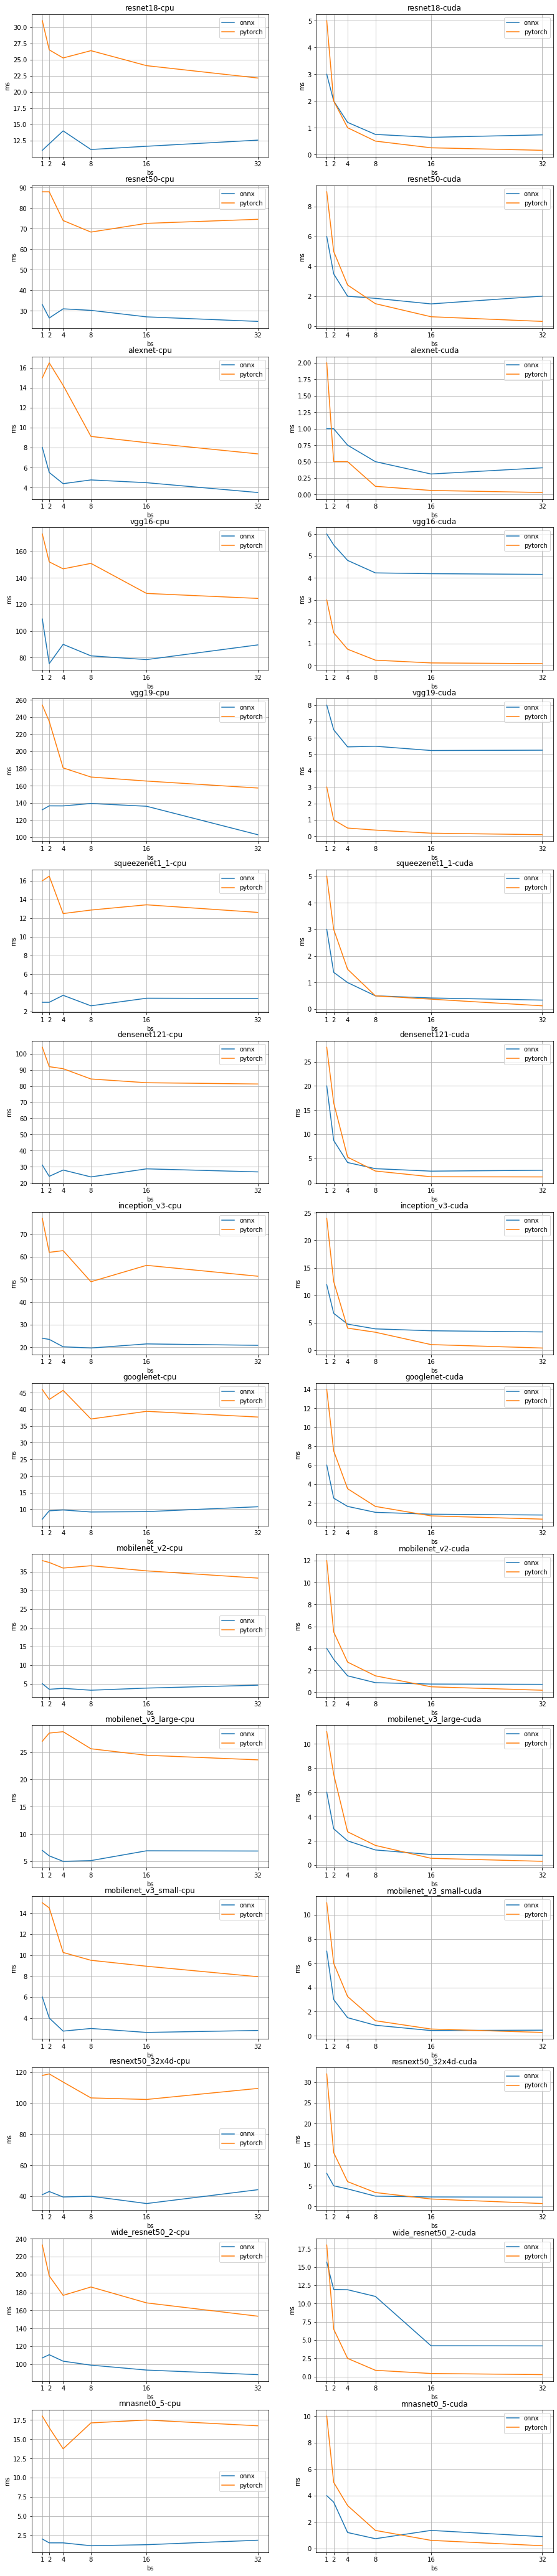

In [90]:
# def plot_results(df, device):
architectures = df.model.unique()
engines = df.engine.unique()

count = len(architectures)

bs = int(np.log2(df.bs.max()))
bs = [2**i for i in range(bs+1)]

fig, axs = plt.subplots(count, len(engines), figsize=(15,75))
axs = axs.flatten()

for i, arch in enumerate(architectures):
    idx = i*2
    
    results = df[df.model == arch]
    
    for e in engines:
        axs[idx].plot(bs, results[(results.device == 'cpu') & (results.engine == e)].time.tolist(), label=e)
        axs[idx+1].plot(bs, results[(results.device == 'cuda') & (results.engine == e)].time.tolist(), label=e)

    for j, dev in enumerate(['cpu', 'cuda']):
        axs[idx+j].set_xticks(bs)
        axs[idx+j].grid()
        axs[idx+j].legend()
        axs[idx+j].set_title(f'{arch}-{dev}')
        axs[idx+j].set_ylabel('ms')
        axs[idx+j].set_xlabel('bs')

plt.show()